In [31]:
import numpy as np # 今回は明示的には使わない
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # 可視化
import lightgbm as lgb # LightGBM でモデルを作成する
from sklearn.metrics import accuracy_score, roc_auc_score #精度評価に使用

In [21]:
# 各種定数の定義
# 乱数シード
RANDOM_SEED = 42
# target となる特徴量
TARGET_COULMN_NAME = "Exited"
# 削除する特徴量のリスト
DROP_COLUMNS = ["id", "CustomerId", "Surname"]
# one-hot encoding する特徴量のリスト
ONE_HOT_ENCODING_COLUMNS = ["Geography", "Gender"]

In [22]:
# 学習データの読み込み
train_df =  pd.read_csv("../input/tdse-inclass-competition-0/train.csv")

# 特徴量。Surname, id, CustomerIDは削除
X_train_df = train_df.drop(
    [TARGET_COULMN_NAME] + DROP_COLUMNS,
    axis=1,
) 
# one-hot encoding
X_train_df = pd.get_dummies(
    X_train_df,
    columns=ONE_HOT_ENCODING_COLUMNS,
)
# 目的変数
y_train_df = train_df[TARGET_COULMN_NAME]

# テストデータの読み込み
test_df =  pd.read_csv("../input/tdse-inclass-competition-0/test.csv")
# 学習データに合わせて特徴量を加工
X_test_df = test_df.drop(
    DROP_COLUMNS,
    axis=1,
)
# one-hot encoding
X_test_df = pd.get_dummies(
    X_test_df,
    columns=ONE_HOT_ENCODING_COLUMNS,
)

# LightGBM用のデータセット作成
train_data = lgb.Dataset(X_train_df, label=y_train_df)

In [23]:
# モデルのパラメータ設定
params = {
    'objective': 'binary', # 2値分類
    'metric': 'auc', # 評価指標は AUC under ROC curve
    'boosting_type': 'gbdt', # 勾配ブースティング
    'learning_rate': 0.05, # 学習率
    'num_leaves': 31, # ノード数
    'feature_fraction': 0.9, # 各ツリーを作成する際の特徴量の使用割合
    'bagging_fraction': 0.8, # 各ツリーを作成する際のデータの使用割合
    'bagging_freq': 5, # バギング (データサンプリング) を行う頻度。5 なら 5回に1回バギングを行う
    'verbose': 0 # 学習中のログ出力の詳細度。0 なら何も出力しない
}

# モデルのトレーニング
model = lgb.train(
    params,
    train_data,
)

In [24]:
# モデルのfeature importance を表示
importance_df = pd.DataFrame(model.feature_importance(), index=X_train_df.columns, columns=["importance"])
importance_df = importance_df.sort_values(by="importance", ascending=False)
importance_df

,importance
Age,582
Balance,552
NumOfProducts,344
CreditScore,291
IsActiveMember,286
Gender_Female,267
Geography_Germany,240
EstimatedSalary,219
Tenure,92
HasCrCard,80


In [25]:
# テストデータに対する予測
y_pred_np = model.predict(X_test_df)

In [26]:
y_pred_np

array([0.02310768, 0.81771536, 0.03368528, ..., 0.01975601, 0.14910902,
       0.18713131])

In [27]:
# 提出用ファイルの作成
submission_df = pd.DataFrame({
    "id": test_df["id"],
    "Exited": y_pred_np,
})

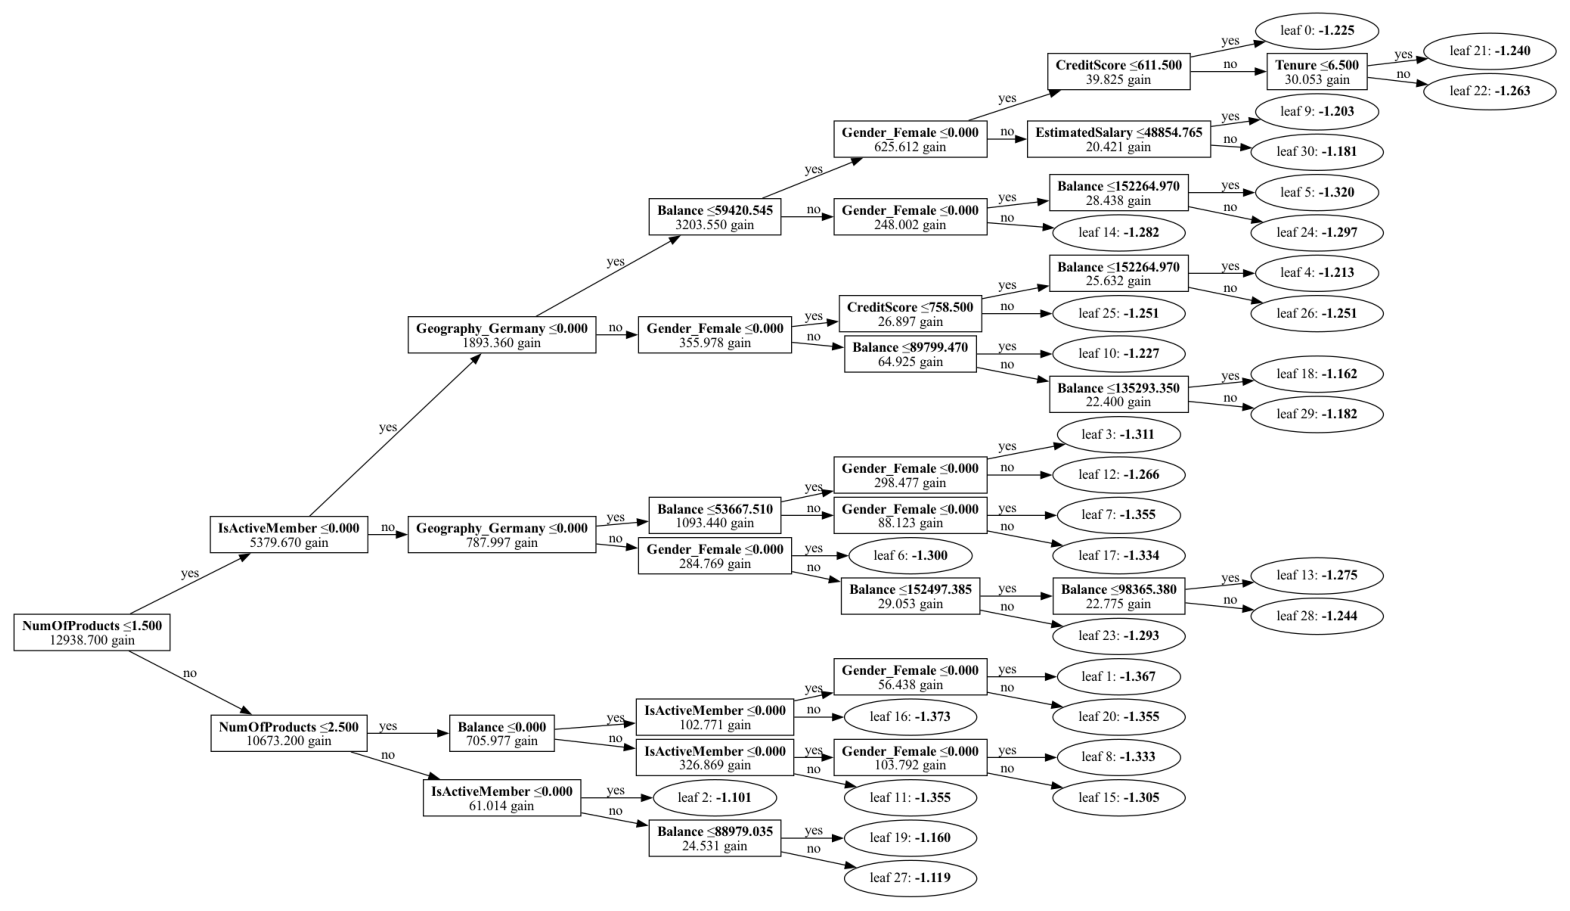

'Tree.gv.png'

In [33]:
ax = lgb.plot_tree(model, tree_index=0, figsize=(20, 20), show_info=['split_gain'])
plt.show()
graph = lgb.create_tree_digraph(model, tree_index=0, format='png', name='Tree')
graph.render(view=True)


In [28]:
submission_df.head()

,id,Exited
0,165034,0.023108
1,165035,0.817715
2,165036,0.033685
3,165037,0.232758
4,165038,0.357747


In [29]:
# submission_df.to_csv("submission.csv", index=False)